In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export 
from exp.nb_04 import *

## Initial setup

In [58]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#export 
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
learn = create_learner(get_model, loss_func, data)
run = Runner(AvgStatsCallback([accuracy]))

In [ ]:
run.fit(3, learn)

In [ ]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner(AvgStatsCallback([accuracy]))
run.fit(3, learn)

In [ ]:
#export 
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [ ]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    
    def plot_loss(self): plt.plot(self.losses)

    
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # % through the learning
            
    def begin_batch(self):
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [ ]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner,start,end)

We can refactor this with a decorator.

In [ ]:
#export
def annealer(f): 
    def _inner(start, end): return partial(f,start,end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [ ]:
f = sched_lin(1,2)
f(0.3)

And here are other scheduler functions:

In [ ]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [ ]:
annealings = "NO LINEAR COS EXP".split()
a = torch.arange(0, 100)
p = torch.linspace(0.01,1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn,t in zip(fns,annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
    
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [41]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0) # cumsum(a,b,c) = (a,a+b, a+b+c)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
#         import pdb;pdb.set_trace()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [42]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

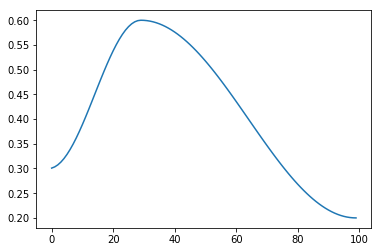

In [43]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [45]:
cbfs = [Recorder,
       partial(ParamScheduler,'lr', sched),
       partial(AvgStatsCallback, accuracy)]

In [46]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [47]:
run.fit(3, learn)

train: [0.799982578125, tensor(0.7788)]
valid: [0.331090087890625, tensor(0.9035)]
train: [0.29341484375, tensor(0.9144)]
valid: [0.2336184814453125, tensor(0.9339)]
train: [0.2325103515625, tensor(0.9341)]
valid: [0.206747705078125, tensor(0.9432)]


... then check with our recorder if the learning rate followed the right schedule.

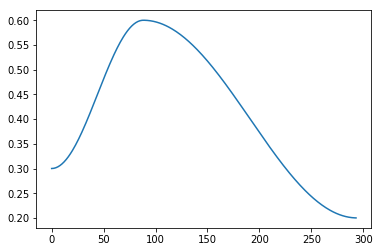

In [48]:
run.recorder.plot_lr()

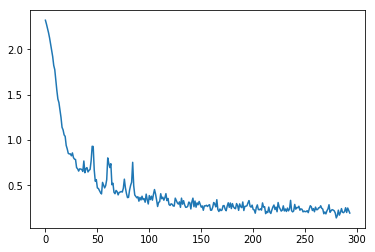

In [49]:
run.recorder.plot_loss()

## Discriminative learning rates

In [ ]:
  class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # % through the learning
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [120]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self): 
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
    
    def set_param(self): 
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [121]:
m = data.train_ds.x.shape[1]
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, data.c))

###### weight, bias scheduling

In [122]:
wgts, biases = [], []
for l in model:
    if hasattr(l, 'weight'): wgts.append(l.weight)
    if hasattr(l, 'bias'): biases.append(l.bias)

In [123]:
biases

[Parameter containing:
 tensor([ 0.0131,  0.0059,  0.0193, -0.0236, -0.0201,  0.0098, -0.0347,  0.0310,
         -0.0056,  0.0269, -0.0010,  0.0024,  0.0006, -0.0166, -0.0337, -0.0022,
         -0.0032, -0.0144,  0.0351, -0.0070, -0.0261, -0.0101, -0.0077,  0.0308,
         -0.0033, -0.0198, -0.0258, -0.0309, -0.0119,  0.0108,  0.0004,  0.0185,
          0.0126, -0.0012, -0.0202, -0.0206, -0.0282, -0.0075,  0.0192, -0.0322,
         -0.0122, -0.0059,  0.0098,  0.0183, -0.0168, -0.0092, -0.0021,  0.0294,
         -0.0227, -0.0322], requires_grad=True), Parameter containing:
 tensor([ 0.1110, -0.0161,  0.0255,  0.0570,  0.0291,  0.1128, -0.0458, -0.0982,
         -0.0536,  0.1357], requires_grad=True)]

In [124]:
#export
def pg_dicts(pgs): return [{'params':o} for o in pgs]

In [125]:
pgs = pg_dicts((wgts, biases))
# pp(pgs, model.parameters)
opt = optim.SGD(pgs, lr=0.1)
learn = Learner(model, opt, loss_func, data)

cos 1cycle scheduling function:

In [126]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start,high),sched_cos(high, end)]

In [127]:
phases = [0.3, 0.7]
sched_w = combine_scheds(phases, cos_1cycle_anneal(0.3, 0.6, 0.2))
sched_b = combine_scheds(phases, cos_1cycle_anneal(0.9, 1.8, 0.6))

Lets do it in a function:

In [128]:
def create_scheds(pct_first, sched_funcs, starts, highs, ends):
    phases = [pct_first, 1-pct_first]
    return [
        combine_scheds(phases, [sched_funcs(s,h), sched_funcs(h,e)])
        for s,h,e in zip(starts, highs, ends)
    ]

In [129]:
scheds = create_scheds(0.3, sched_cos, (0.3, 0.9), (0.6, 1.8), (0.2, 0.6))

In [130]:
cbfs = [Recorder, 
       partial(AvgStatsCallback, accuracy),
       partial(ParamScheduler, 'lr', scheds)]

In [131]:
run = Runner(cb_funcs=cbfs)

In [132]:
run.fit(3, learn)

train: [0.78583859375, tensor(0.7824)]
valid: [0.3348346923828125, tensor(0.9026)]
train: [0.30409107421875, tensor(0.9103)]
valid: [0.2357609130859375, tensor(0.9338)]
train: [0.24009734375, tensor(0.9317)]
valid: [0.2131322998046875, tensor(0.9382)]


In [133]:
camel2snake('Recorder')

'recorder'

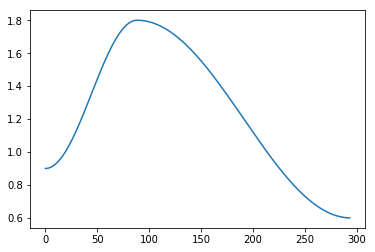

In [134]:
run.recorder.plot_lr()

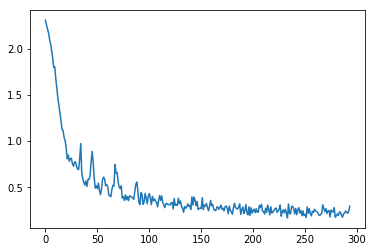

In [135]:
run.recorder.plot_loss()

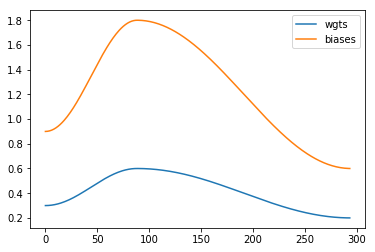

In [136]:
plt.plot(run.recorder.lrs[0])
plt.plot(run.recorder.lrs[1])
plt.legend(['wgts', 'biases']);

## Export

In [97]:
!python notebook2script.py 05_anneal-Copy1.ipynb

Converted 05_anneal-Copy1.ipynb to exp/nb_05.py
